# 🔥 Trader Behavior Insights Analysis:-

# 🧠 Objective:-


To analyze how market sentiment (Fear & Greed Index) affects trader behavior and profitability. The project combines historical trading data with sentiment indicators to extract actionable insights and recommend smarter trading strategies.



# 📊  Datasets Used


(1) Bitcoin Market Sentiment (Fear & Greed Index):-
* Fields: timestamp, value (0–100), classification (Fear, Greed, Neutral), date

(2) Historical Trader Data:-
* Fields: Account, Coin, Execution Price, Size Tokens, Size USD, Side, Date, Start Position, Direction, Closed PnL, Transaction Hash, Order ID, Crossed, Fee, Trade ID, Timestamp



# (1) Data Collection & Preprocessing

In [1]:
# Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, silhouette_score

# Load datasets
trades_df = pd.read_csv("historical_data.csv", parse_dates=['date'])
fgi_df= pd.read_csv("fear_greed_index.csv", parse_dates=['date'])

# Merge on date
merged_df = pd.merge(trades_df, fgi_df, on='date', how='inner')

# Handle missing values
merged_df.dropna(inplace=True)

# Drop duplicates or rows with missing sentiment
merged_df.dropna(subset=["value", "classification"], inplace=True)

# Preview
merged_df.isnull().sum()
print(trades_df.head())
print(fgi_df.head())
print(merged_df.describe())
print(merged_df['classification'].value_counts())

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side       date  Start Position Direction  \
0       986.87   7872.16  BUY 2024-12-02        0.000000       Buy   
1        16.00    127.68  BUY 2024-12-02      986.524596       Buy   
2       144.09   1150.63  BUY 2024-12-02     1002.518996       Buy   
3       142.98   1142.04  BUY 2024-12-02     1146.558564       Buy   
4         8.73     69.75  BUY 2024-12-02     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac... 

# (2) Exploratory Data Analysis (EDA)


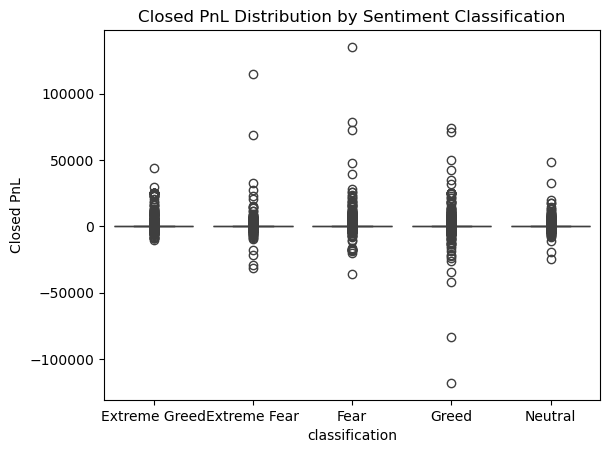

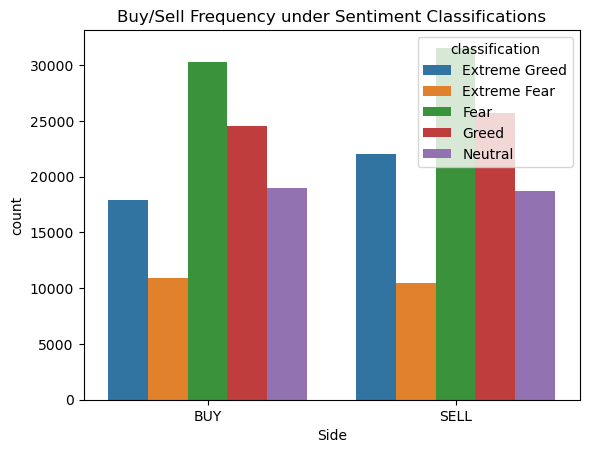

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of PnL under different sentiment classifications
sns.boxplot(x='classification', y='Closed PnL', data=merged_df)
plt.title("Closed PnL Distribution by Sentiment Classification")
plt.show()

# Buy vs Sell activity during sentiment types
sns.countplot(x='Side', hue='classification', data=merged_df)
plt.title("Buy/Sell Frequency under Sentiment Classifications")
plt.show()


# (A) Sentiment classification vs. Closed PnL:-
* Insight: Most losses occur during Fear phases.

* Visualization: Boxplot of PnL across sentiments

# (B) Buy/Sell Activity by Sentiment classifications:-
* More Buy orders during Greed

* More Sell orders during Fear



# (3) Behavior Clustering

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


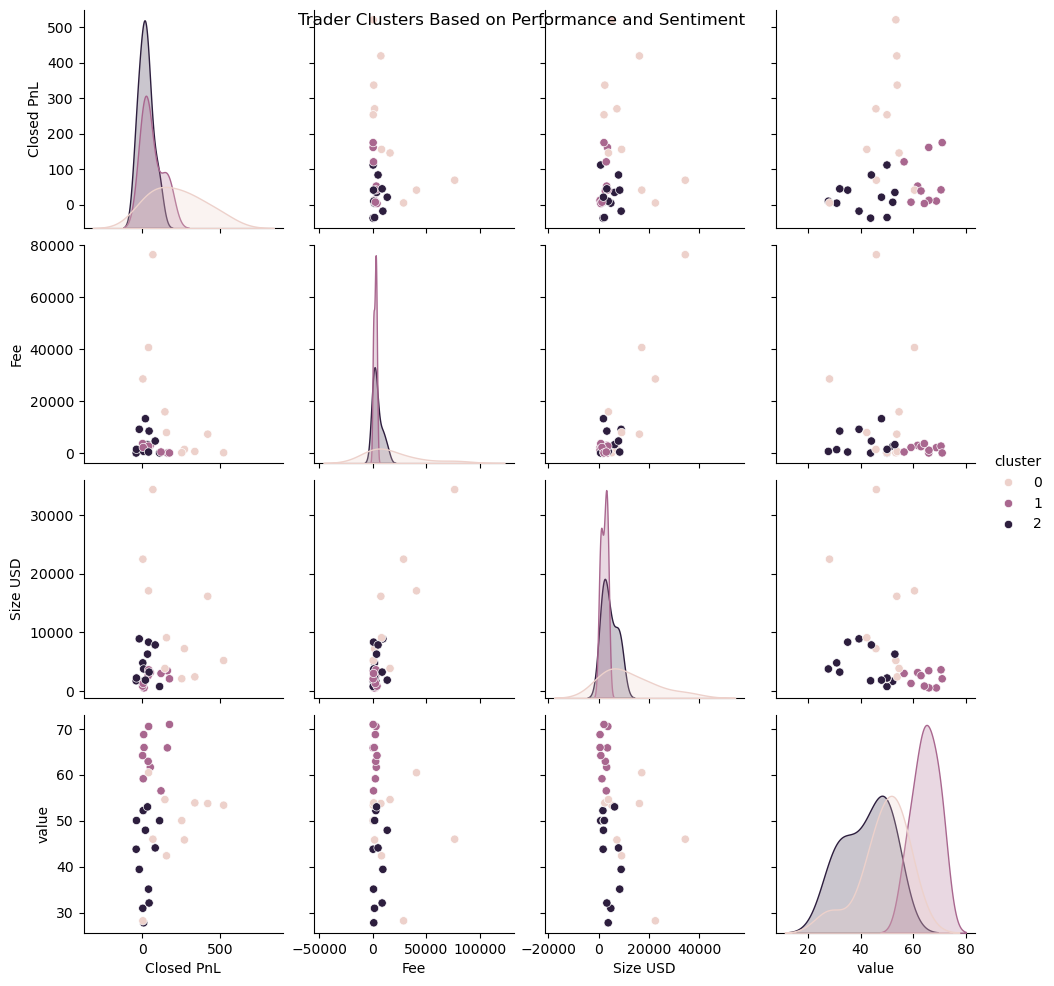

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Aggregate per trader
agg = merged_df.groupby('Account').agg({
    'Closed PnL': 'mean',
    'Fee': 'sum',
    'Size USD': 'mean',
    'value': 'mean'
}).reset_index()

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(agg.drop('Account', axis=1))

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
agg['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters
sns.pairplot(agg, hue='cluster')
plt.suptitle("Trader Clusters Based on Performance and Sentiment")
plt.show()


 # (4) Modeling Trader Response to Sentiment


              precision    recall  f1-score   support

           0       0.77      0.80      0.78     24871
           1       0.69      0.66      0.68     17373

    accuracy                           0.74     42244
   macro avg       0.73      0.73      0.73     42244
weighted avg       0.74      0.74      0.74     42244

ROC AUC Score: 0.7289


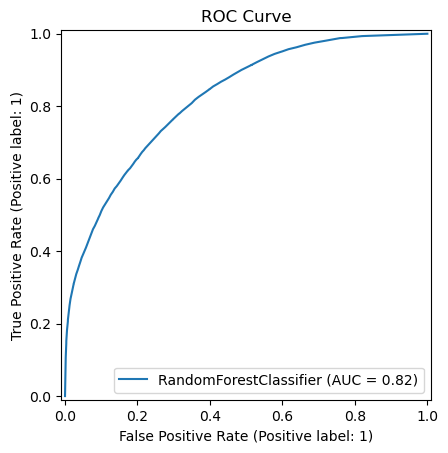

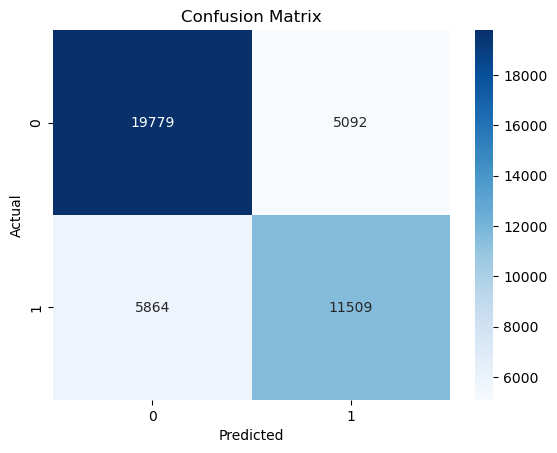

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Label: Did trader make profit?
merged_df['profitable'] = (merged_df['Closed PnL'] > 0).astype(int)

# Features
features = ['value', 'Size USD', 'Fee']
X = merged_df[features]
y = merged_df['profitable']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

# ROC Curve
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc:.4f}")
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve")
plt.show()


# (5) Confusion matrix


In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# (6) Feature Importance

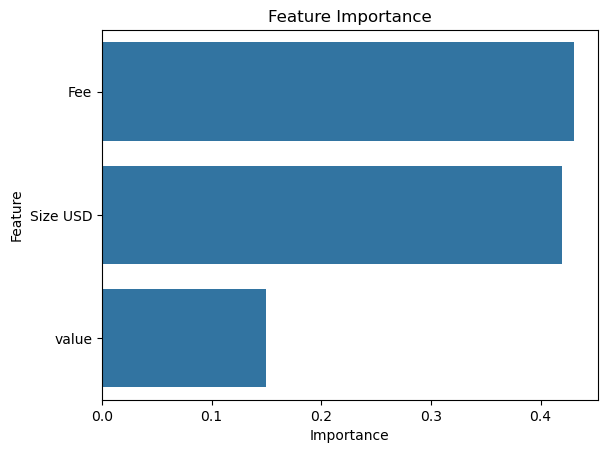

In [5]:
importances = clf.feature_importances_
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df.sort_values(by="Importance", ascending=False, inplace=True)

sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title("Feature Importance")
plt.show()


# 🧠 Key Insights:-



* Traders tend to buy more during Greed and sell more during Fear.
  
* Losses are higher during fearful sentiment periods.

* Certain trader clusters are consistently profitable regardless of sentiment, indicating the presence of experienced traders.

* High market sentiment value does not always correlate with high PnL, suggesting overconfidence during greedy times.


